In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import sys 

%matplotlib inline

In [2]:
sys.path.append(os.path.abspath('../src/data'))

try:
    import bsautils as utils 
except ImportError as e:
    print(f'Trouble: {e}')

In [3]:
data_dir = '/Users/davidriser/data/kaon'
data = pd.read_csv(f'{data_dir}/kaon.csv.gzip', compression='gzip', nrows=None)

In [4]:
filters = utils.build_filter(data)
filters.append('helicity != 0')

In [5]:
data = utils.build_dataframe(data, filters)

In [6]:
data.groupby('sector').aggregate({'meson_id':'count'})

,meson_id
sector,
1,213799
2,226505
3,198513
4,192757
5,197880
6,190317


In [7]:
def six_pane_sector_plot(data, axis, bins, opts):
    fig = plt.figure(figsize=(12,6))
    axes = []
    for s,sdata in data.groupby('sector'):
        ax = fig.add_subplot(3,2,s)
        ax.hist(sdata[axis], bins=bins, label=f'Sector {s}', **opts)
        ax.legend(frameon=False)
        axes.append(ax)
       
    fig.tight_layout()
    return fig, axes

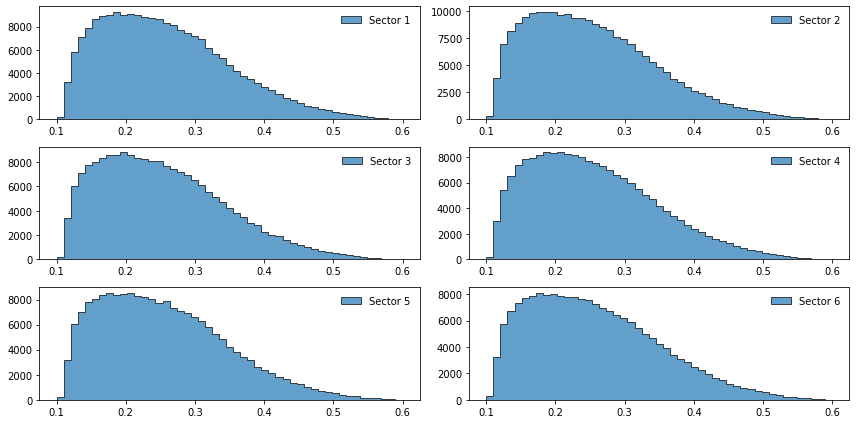

In [8]:
opts = {'alpha':0.7, 'edgecolor':'k', 'histtype':'stepfilled'}
fig, axes = six_pane_sector_plot(data, 'x', np.linspace(0.1, 0.6, 50), opts)


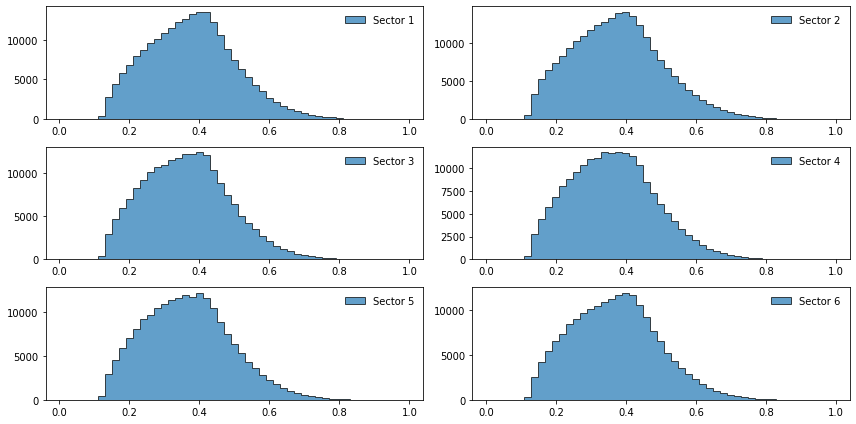

In [9]:
fig, axes = six_pane_sector_plot(data, 'z', np.linspace(0.01, 0.99, 50), opts)

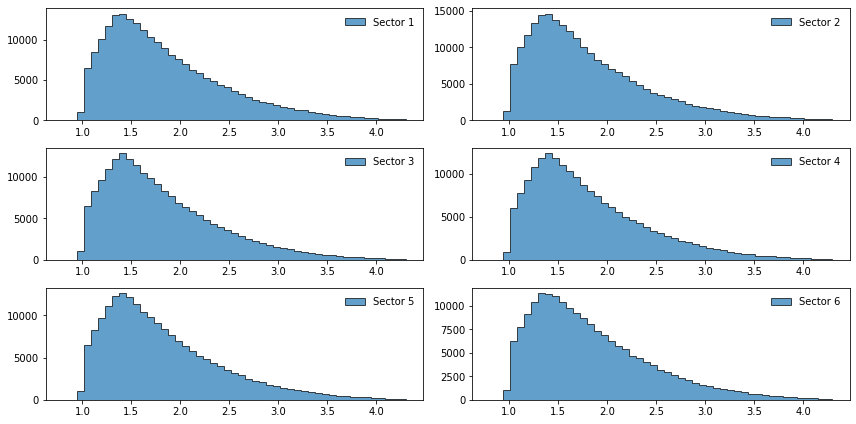

In [10]:
fig, axes = six_pane_sector_plot(data, 'q2', np.linspace(0.8, 4.3, 50), opts)

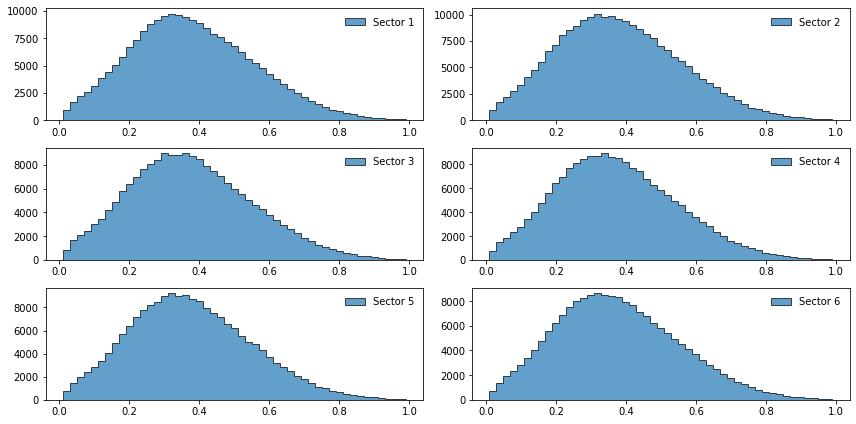

In [11]:
fig, axes = six_pane_sector_plot(data, 'pt', np.linspace(0.01, 0.99, 50), opts)

In [12]:
counts = data.groupby('sector').aggregate({'meson_id':'count'}).reset_index()
counts.columns = ['sector', 'counts']

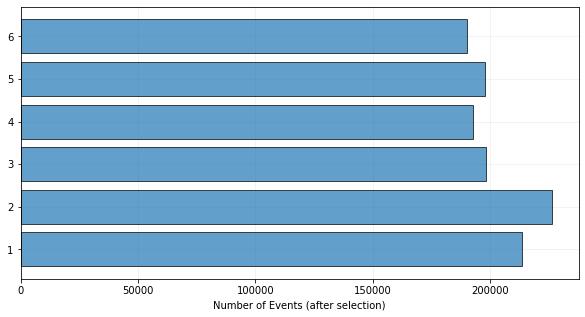

In [13]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.barh(counts['sector'], counts['counts'], edgecolor='k', alpha=0.7)
ax.set_xlabel('Number of Events (after selection)')
ax.set_axisbelow(True)
ax.grid(alpha=0.2)

In [14]:
counts = data.groupby(['sector', 'helicity']).aggregate({'meson_id':'count'}).reset_index()
counts.columns = ['sector', 'helicity', 'counts']

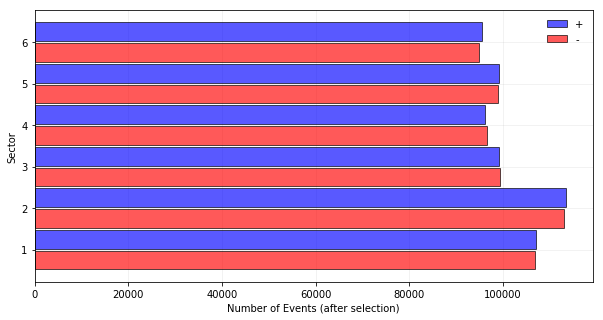

In [15]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
axes = [] 

for h, hcounts in counts.groupby('helicity'):
    color = 'red' if h > 0 else 'blue'
    for s, scounts in hcounts.groupby('sector'):
        shift = -0.25 if h > 0 else 0.25 

        axes.append(
            ax.barh(y = s + shift, 
                    width = scounts['counts'], 
                    height = 0.45,
                    edgecolor='k', alpha=0.65, color=color)
        )

ax.set_xlabel('Number of Events (after selection)')
ax.set_ylabel('Sector')
ax.set_axisbelow(True)
ax.grid(alpha=0.2)
ax.legend((axes[0], axes[7]), ['+', '-'], frameon=False)

In [16]:
def bihisto_plot(x1, x2, bins):
    counts1, axis = np.histogram(x1, bins)
    counts2, _ = np.histogram(x2, bins)

    width = (bins[1] - bins[0])
    axis = axis[:-1] + width
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    
    ax.bar(x=axis, height= counts1, width=width, edgecolor='k', alpha=0.7, color='orange')
    ax.bar(x=axis, height=-counts2, width=width, edgecolor='k', alpha=0.7, color='orange')
    ax.grid(alpha=0.2)
    ax.set_axisbelow(True)

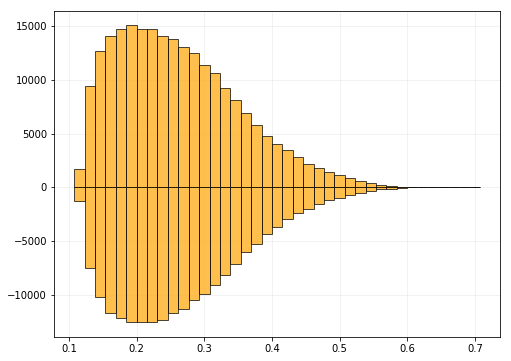

In [17]:
bihisto_plot(data.query('sector == 2')['x'], data.query('sector == 4')['x'], np.linspace(0.1, 0.7, 40))

In [18]:
def dhisto_plot(x1, x2, bins, normed=False):
    counts1, axis = np.histogram(x1, bins)
    counts2, _ = np.histogram(x2, bins)

    width = (bins[1] - bins[0])
    axis = axis[:-1] + width
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    
    d = counts2 - counts1
    if normed:
        d = np.divide(d, counts2)
        
    ax.bar(x=axis, height=d, width=width, edgecolor='k', alpha=0.7, color='orange')
    ax.grid(alpha=0.2)
    ax.set_axisbelow(True)

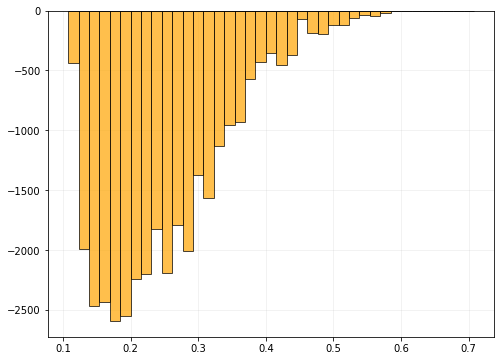

In [19]:
dhisto_plot(data.query('sector == 2')['x'], data.query('sector == 4')['x'], np.linspace(0.1, 0.7, 40), normed=False)

In [20]:
xbins = np.linspace(0.1, 0.7, 6)
q2bins = np.linspace(1,4,4)
zbins = np.linspace(0,1,9)
ptbins = np.linspace(0,1,9)

data['xbin'] = np.digitize(data['x'], xbins) 
data['q2bin'] = np.digitize(data['q2'], q2bins) 
data['zbin'] = np.digitize(data['z'], zbins) 
data['ptbin'] = np.digitize(data['pt'], ptbins) 

Using (2, 3)


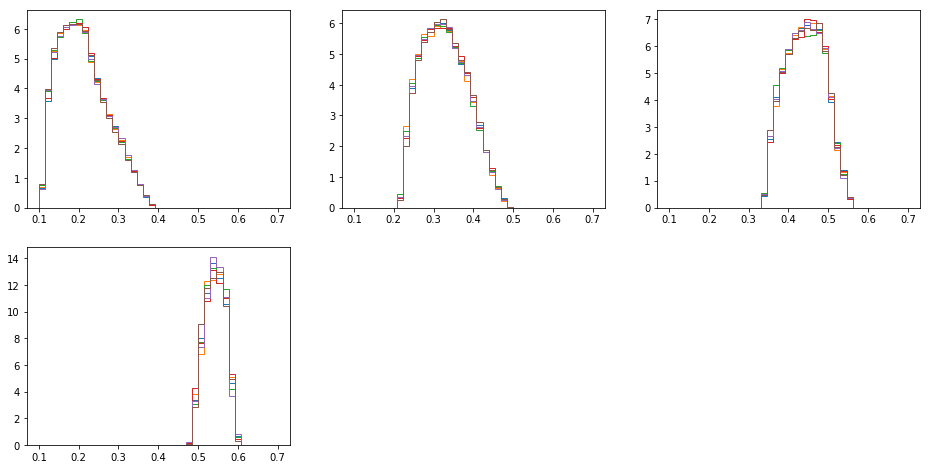

In [21]:
npads = len(q2bins) - 1
pad = 1
ncols = 3 
nrows = npads // ncols + 1 
print(f'Using {nrows,ncols}')
plt.figure(figsize=(16,8))

for q2, q2data in data.groupby('q2bin'):
    plt.subplot(nrows,ncols,pad)
    pad += 1
    
    for s, sdata in q2data.groupby('sector'):
        plt.hist(sdata['x'], histtype='step', bins=np.linspace(0.1, 0.7, 40), density=True)

In [22]:
from scipy.stats import ks_2samp

In [23]:
def get_pvals(data, axis):
    pvals = np.zeros(shape=(6,6))
    ksvals = np.zeros(shape=(6,6))
    for s1, s1data in data.groupby('sector'):
        for s2, s2data in data.groupby('sector'):
            ksval, kspval = ks_2samp(s1data[axis], s2data[axis])
            pvals[s1-1,s2-1] = kspval
            ksvals[s1-1,s2-1] = ksval
            
    return pvals

In [24]:
pvals = {} 
for axis in ['x', 'q2', 'z', 'pt']:
    pvals[axis] = get_pvals(data,axis)

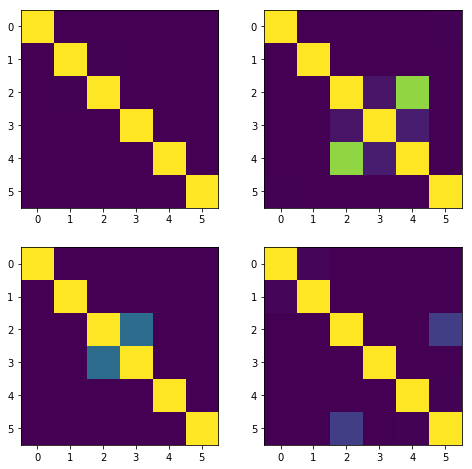

In [25]:
pad = 1
plt.figure(figsize=(8,8))
for axis in ['x', 'q2', 'z', 'pt']:
    plt.subplot(2,2,pad)
    plt.imshow(pvals[axis])
    pad += 1

# Look at Asymmetry
Integrated over everything

In [29]:
data['phi_bin'] = np.digitize(data['phi_h'], np.linspace(-180, 180, 25))
phi = np.linspace(-180, 180, 25)
phi = (phi[1]-phi[0]) + phi[:-1]

In [30]:
def npos(x):
    return len(np.where(x > 0)[0])

def nneg(x):
    return len(np.where(x < 0)[0])

def asym(x):
    xp = npos(x)
    xm = nneg(x)
    return (xp - xm) / (xp + xm) / 0.75

def dasym(x):
    xp = npos(x)
    xm = nneg(x)
    tot = xp+xm
    asy = asym(x)
    return np.sqrt((1 - asy)**2 / tot)

In [31]:
asym_data = data.groupby(['sector', 'phi_bin']).aggregate({
    'helicity':[asym, dasym, npos, nneg]
}).reset_index()
asym_data.columns = ['sector', 'phi_bin', 'asym', 'err', 'pos', 'neg']

In [32]:
asym_data

,sector,phi_bin,asym,err,pos,neg
0,1,1,-0.001589,0.007732,8380,8400
1,1,2,-0.016369,0.008848,6517,6679
2,1,3,0.001973,0.010261,4737,4723
3,1,4,-0.011374,0.010444,4649,4729
4,1,5,-0.042502,0.009796,5482,5843
...,...,...,...,...,...,...
139,6,20,0.031349,0.010374,4462,4257
140,6,21,0.009561,0.011631,3652,3600
141,6,22,-0.001319,0.011135,4039,4047
142,6,23,-0.003154,0.009220,5905,5933


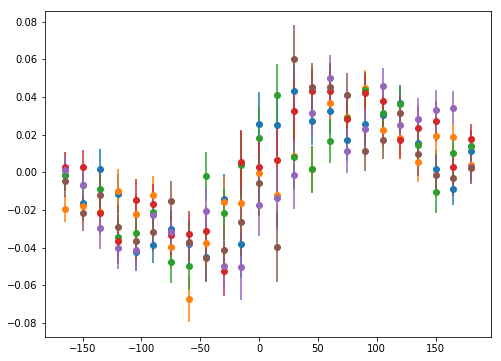

In [33]:
plt.figure(figsize=(8,6))
for s, sdata in asym_data.groupby('sector'):
    #if s in [3,4,5]:
        #plt.bar(phi, sdata['pos']-sdata['neg'])
    plt.errorbar(phi, sdata['asym'], sdata['err'], marker='o', linestyle='')

In [54]:
def rmse(x):
    return np.sqrt(np.mean((x - np.mean(x))**2))

def root_mean_squared_error(data):
    '''Calculate the RMSE over sectors from 
    the dataframe. '''

    aggs = data.groupby('phi_bin').aggregate({'asym':rmse}).reset_index()
    aggs.columns = ['phi_bin', 'rmse']
    return aggs['rmse'].sum()

In [55]:
root_mean_squared_error(asym_data)

0.3045714513635054

In [63]:
bounding_axes = ['x', 'q2', 'z', 'pt']

In [64]:
bounds = {} 

for axis in bounding_axes:
    bounds[axis] = [data[axis].min(), data[axis].max()]

In [65]:
bounds

{'x': [0.10681463778018953, 0.5997105836868286],
 'q2': [1.0000007152557373, 4.740612983703613],
 'z': [0.1212601587176323, 0.8590466380119324],
 'pt': [0.00022696680389344687, 1.2464019060134888]}

In [66]:
tightest_bounds = {
    'x': [0.15, 0.55],
    'q2': [1.4, 4.5],
    'z': [0.3, 0.7],
    'pt': [0.1, 0.85]
}

In [90]:
def points_in_z_range(x, z_max):
    z_pos = np.abs(x - x.mean()) / x.std()
    return len(np.where(z_pos < z_max)[0])

def points_metric_df(data):
    '''Calculate the RMSE over sectors from 
    the dataframe. '''

    metric = lambda x: points_in_z_range(x, z_max=1.0)
    aggs = data.groupby('phi_bin').aggregate({'asym':metric}).reset_index()
    aggs.columns = ['phi_bin', 'npoints']
    return aggs['npoints'].sum()

In [91]:
deltas

{'x': [0.00042510590935125673, -0.0004893385581672127],
 'q2': [0.0039374929592013, -0.00236853405833255],
 'z': [0.002010823214426638, -0.0017892746776342339],
 'pt': [0.0011224466234561984, -0.004459521442651729]}

In [92]:
n_samples = 10 * len(bounding_axes)

deltas = {}

for axis in bounding_axes:
    deltas[axis] = [(tightest_bounds[axis][i] - bounds[axis][i]) / n_samples 
                    for i in range(2)]
print(deltas)

outdata = {}
outdata['x_min'] = []
outdata['x_max'] = []
outdata['q2_min'] = []
outdata['q2_max'] = []
outdata['z_min'] = []
outdata['z_max'] = []
outdata['pt_min'] = []
outdata['pt_max'] = []
outdata['rmse'] = [] 
outdata['npoints'] = [] 

for i in range(n_samples):
    axis = i % len(bounding_axes)
    axis_str = bounding_axes[axis]
    query = '{} > {} and {} < {}'.format(bounding_axes[axis], bounds[axis_str][0], 
                                             bounding_axes[axis], bounds[axis_str][1])
    print(query)
    d = data.query(query)

    
    asym_data = d.groupby(['sector', 'phi_bin']).aggregate({
    'helicity':[asym, dasym, npos, nneg]}).reset_index()
    asym_data.columns = ['sector', 'phi_bin', 'asym', 'err', 'pos', 'neg']
    
    outdata['x_min'].append(bounds['x'][0])
    outdata['x_max'].append(bounds['x'][1])
    outdata['q2_min'].append(bounds['q2'][0])
    outdata['q2_max'].append(bounds['q2'][1])
    outdata['z_min'].append(bounds['z'][0])
    outdata['z_max'].append(bounds['z'][1])
    outdata['pt_min'].append(bounds['pt'][0])
    outdata['pt_max'].append(bounds['pt'][1])
    
    outdata['rmse'].append(root_mean_squared_error(asym_data))
    outdata['npoints'].append(points_in_z_range(asym_data['asym'], z_max=1.0))
    
    bounds[axis_str][0] += deltas[axis_str][0]
    bounds[axis_str][1] += deltas[axis_str][1]

{'x': [0.00031882943201343926, -0.0003670039186254026], 'q2': [0.002953119719400971, -0.0017764005437494567], 'z': [0.0015081174108199785, -0.0013419560082256754], 'pt': [0.0008418349675921487, -0.0033446410819888]}
x > 0.13724682271946242 and x < 0.5646801567450161
q2 > 1.281875211223961 and q2 < 4.571056021749978
z > 0.23967530356720085 and z < 0.753678240329027
pt > 0.06632660129631406 and pt < 0.983785643279552
x > 0.13756565215147587 and x < 0.5643131528263907
q2 > 1.2848283309433621 and q2 < 4.5692796212062285
z > 0.2411834209780208 and z < 0.7523362843208012
pt > 0.0671684362639062 and pt < 0.9804410021975631
x > 0.13788448158348932 and x < 0.5639461489077653
q2 > 1.2877814506627632 and q2 < 4.567503220662479
z > 0.24269153838884078 and z < 0.7509943283125755
pt > 0.06801027123149835 and pt < 0.9770963611155743
x > 0.13820331101550276 and x < 0.5635791449891399
q2 > 1.2907345703821642 and q2 < 4.565726820118729
z > 0.24419965579966074 and z < 0.7496523723043498
pt > 0.0688521061

In [93]:
results = pd.DataFrame(outdata)

In [94]:
results.sort_values('rmse')

,x_min,x_max,q2_min,q2_max,z_min,z_max,pt_min,pt_max,rmse,npoints
28,0.139479,0.562111,1.302547,4.558621,0.250232,0.744285,0.072219,0.960373,0.303195,86
24,0.139160,0.562478,1.299594,4.560398,0.248724,0.745627,0.071378,0.963718,0.303373,86
16,0.138522,0.563212,1.293688,4.563950,0.245708,0.748310,0.069694,0.970407,0.303650,84
20,0.138841,0.562845,1.296641,4.562174,0.247216,0.746968,0.070536,0.967062,0.303978,86
36,0.140116,0.561377,1.308453,4.555068,0.253248,0.741601,0.073903,0.953684,0.304085,85
0,0.137247,0.564680,1.281875,4.571056,0.239675,0.753678,0.066327,0.983786,0.304278,87
32,0.139797,0.561744,1.305500,4.556845,0.251740,0.742943,0.073061,0.957029,0.304413,85
8,0.137884,0.563946,1.287781,4.567503,0.242692,0.750994,0.068010,0.977096,0.304597,85
4,0.137566,0.564313,1.284828,4.569280,0.241183,0.752336,0.067168,0.980441,0.304608,86
12,0.138203,0.563579,1.290735,4.565727,0.244200,0.749652,0.068852,0.973752,0.305392,84


In [95]:
results.corr()

,x_min,x_max,q2_min,q2_max,z_min,z_max,pt_min,pt_max,rmse,npoints
x_min,1.000000,-1.000000,0.988937,-0.988937,0.985185,-0.985185,0.988826,-0.988826,0.129167,-0.088075
x_max,-1.000000,1.000000,-0.988937,0.988937,-0.985185,0.985185,-0.988826,0.988826,-0.129167,0.088075
q2_min,0.988937,-0.988937,1.000000,-1.000000,0.988937,-0.988937,0.985184,-0.985184,0.172095,-0.056728
q2_max,-0.988937,0.988937,-1.000000,1.000000,-0.988937,0.988937,-0.985184,0.985184,-0.172095,0.056728
z_min,0.985185,-0.985185,0.988937,-0.988937,1.000000,-1.000000,0.988826,-0.988826,0.034175,-0.178819
z_max,-0.985185,0.985185,-0.988937,0.988937,-1.000000,1.000000,-0.988826,0.988826,-0.034175,0.178819
pt_min,0.988826,-0.988826,0.985184,-0.985184,0.988826,-0.988826,1.000000,-1.000000,0.043653,-0.084572
pt_max,-0.988826,0.988826,-0.985184,0.985184,-0.988826,0.988826,-1.000000,1.000000,-0.043653,0.084572
rmse,0.129167,-0.129167,0.172095,-0.172095,0.034175,-0.034175,0.043653,-0.043653,1.000000,0.636004
npoints,-0.088075,0.088075,-0.056728,0.056728,-0.178819,0.178819,-0.084572,0.084572,0.636004,1.000000


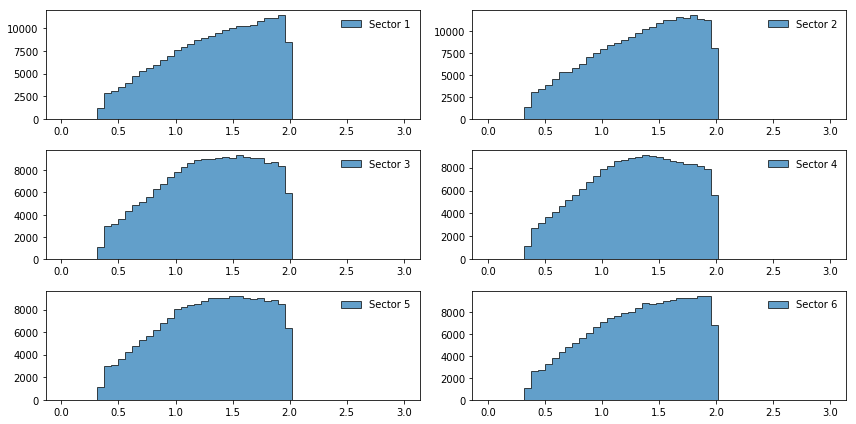

In [96]:
fig, axes = six_pane_sector_plot(data, 'p_mes', np.linspace(0.01, 2.99, 50), opts)

In [97]:
data.columns

Index(['Unnamed: 0', 'alpha', 'dist_cc', 'dist_cc_theta', 'dist_dcr1',
       'dist_dcr3', 'dist_ec_edep', 'dist_ecsf', 'dist_ecu', 'dist_ecv',
       'dist_ecw', 'dist_vz', 'dvz', 'eta', 'helicity', 'meson_id',
       'missing_mass', 'p_ele', 'p_mes', 'phi_ele', 'phi_h', 'phi_mes', 'pt',
       'q2', 'sector', 'theta_ele', 'theta_h', 'theta_mes', 'w', 'x', 'z',
       'xbin', 'q2bin', 'zbin', 'ptbin', 'phi_bin'],
      dtype='object')

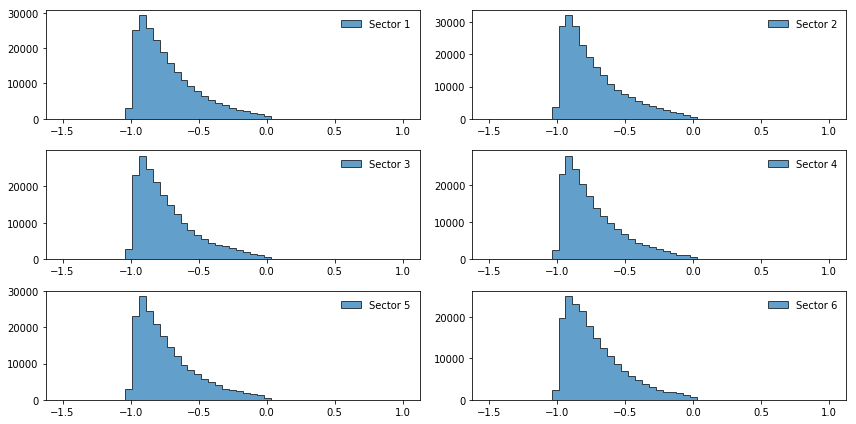

In [100]:
fig, axes = six_pane_sector_plot(data, 'dist_cc', np.linspace(-1.5, 1.0, 50), opts)

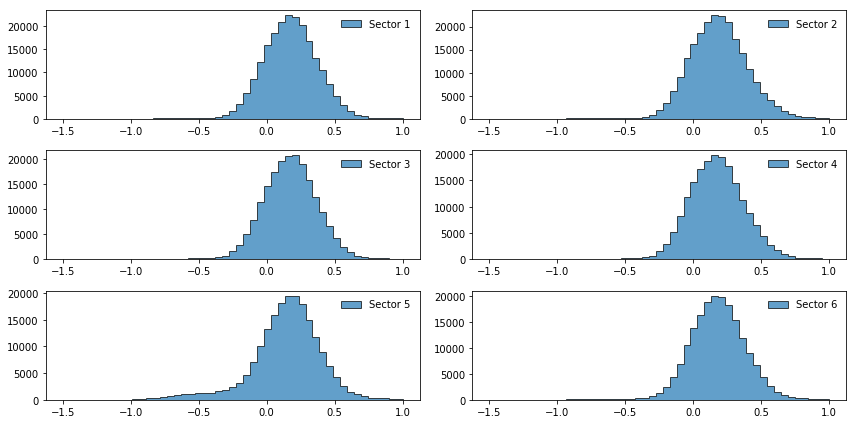

In [101]:
fig, axes = six_pane_sector_plot(data, 'dist_cc_theta', np.linspace(-1.5, 1.0, 50), opts)

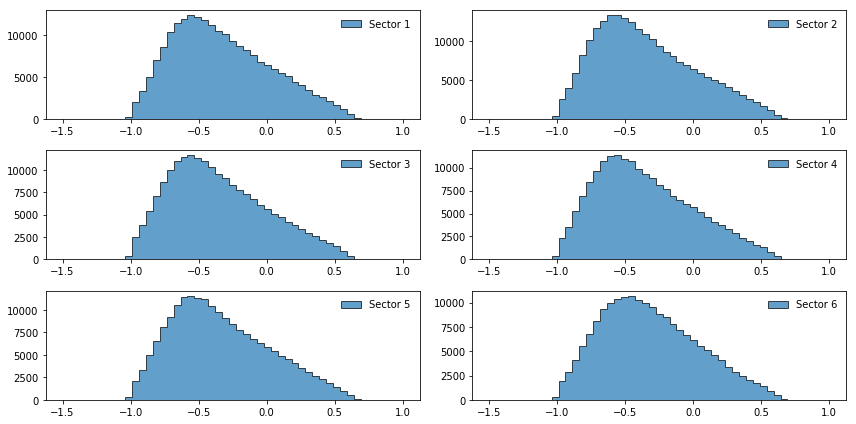

In [102]:
fig, axes = six_pane_sector_plot(data, 'dist_dcr1', np.linspace(-1.5, 1.0, 50), opts)

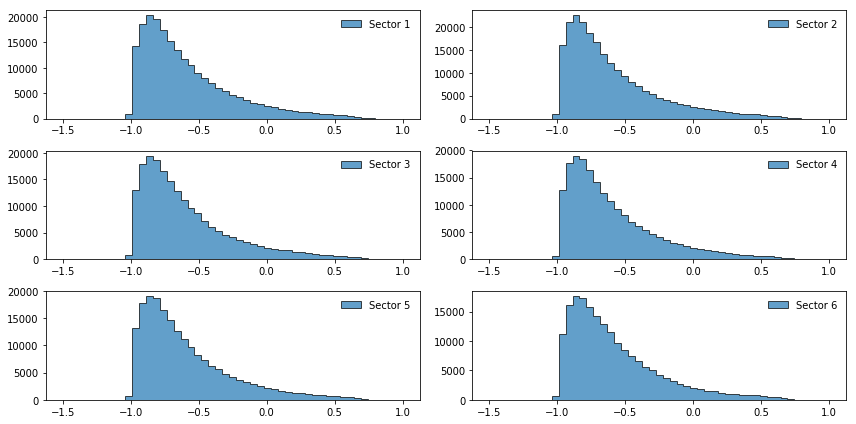

In [103]:
fig, axes = six_pane_sector_plot(data, 'dist_dcr3', np.linspace(-1.5, 1.0, 50), opts)

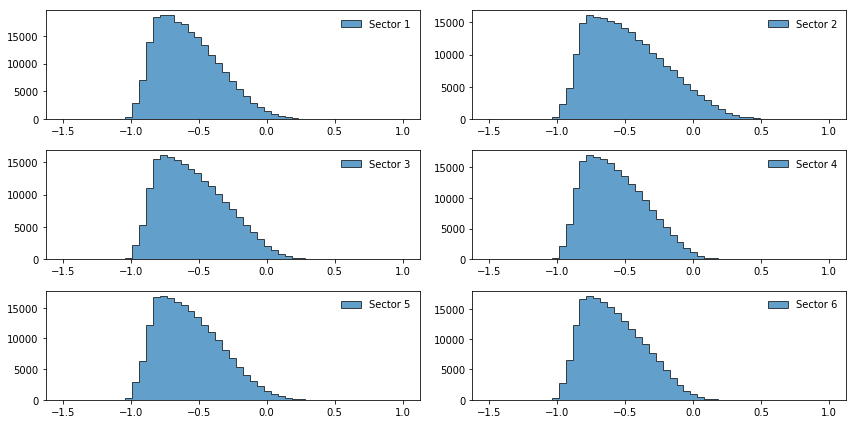

In [104]:
fig, axes = six_pane_sector_plot(data, 'dist_ec_edep', np.linspace(-1.5, 1.0, 50), opts)

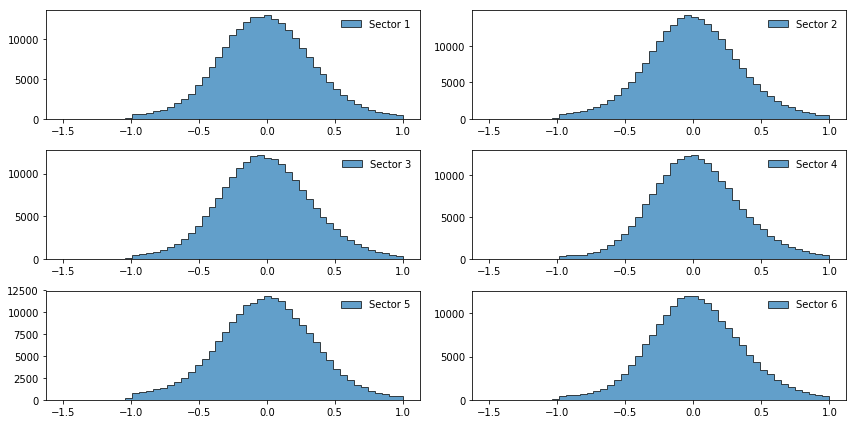

In [105]:
fig, axes = six_pane_sector_plot(data, 'dist_ecsf', np.linspace(-1.5, 1.0, 50), opts)

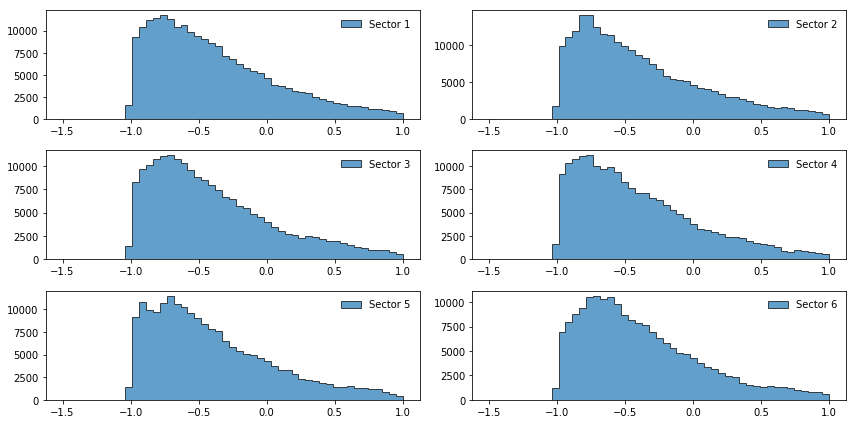

In [106]:
fig, axes = six_pane_sector_plot(data, 'dist_ecu', np.linspace(-1.5, 1.0, 50), opts)

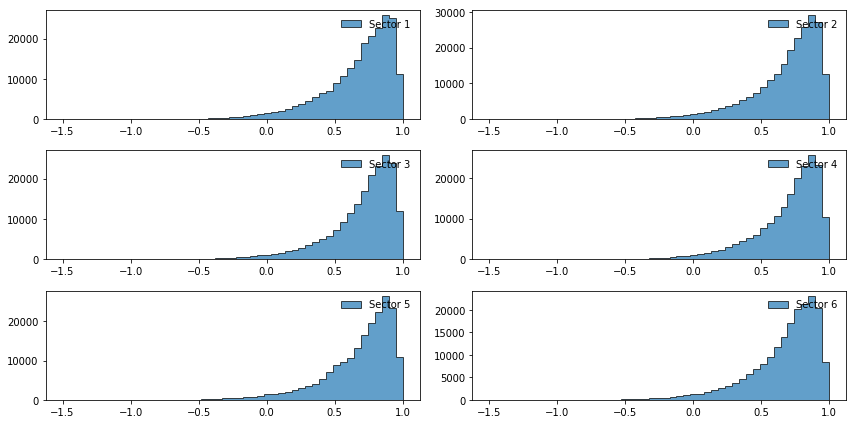

In [107]:
fig, axes = six_pane_sector_plot(data, 'dist_ecv', np.linspace(-1.5, 1.0, 50), opts)

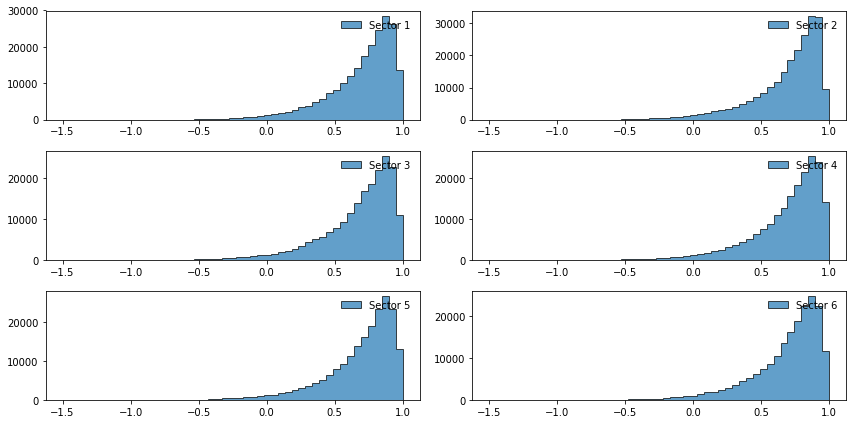

In [108]:
fig, axes = six_pane_sector_plot(data, 'dist_ecw', np.linspace(-1.5, 1.0, 50), opts)

In [110]:
pvals = {} 
for axis in (c for c in data.columns if 'dist' in c):
    pvals[axis] = get_pvals(data, axis)

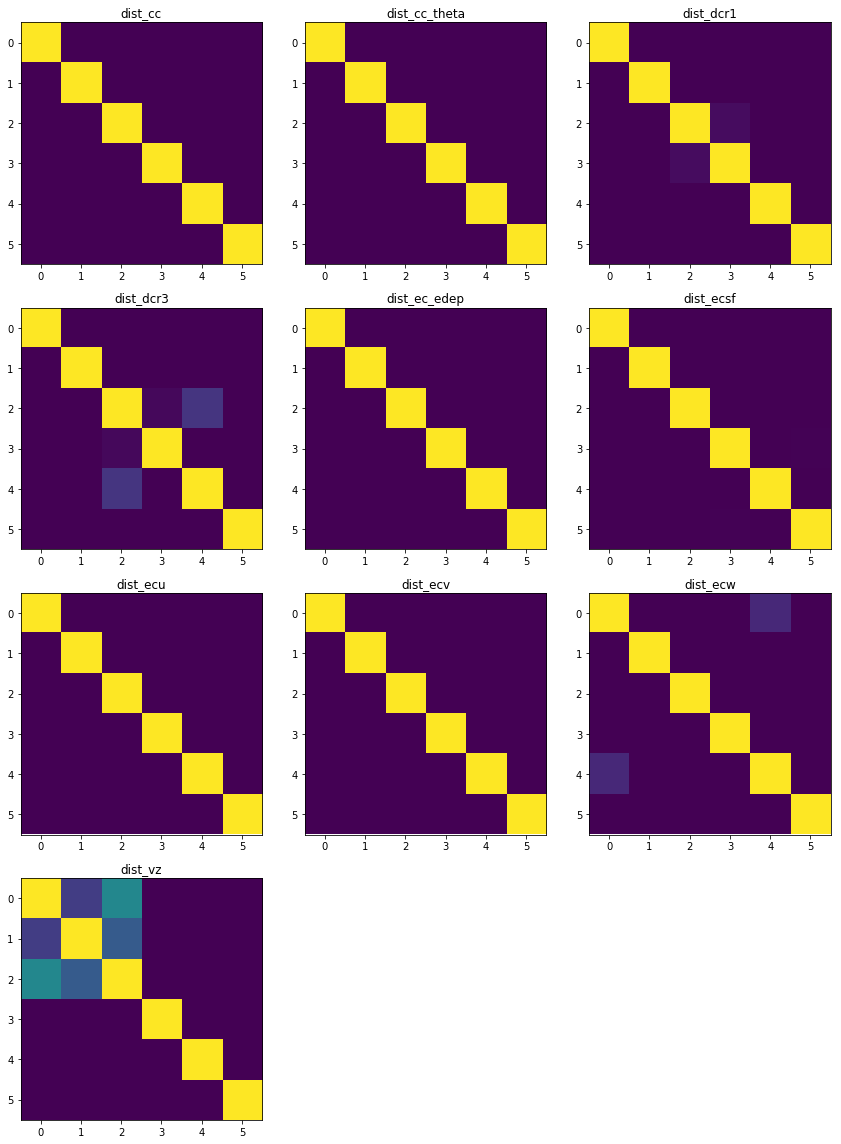

In [118]:
plt.figure(figsize=(12,16))

i = 1
for axis, matrix in pvals.items():
    plt.subplot(4,3,i)
    plt.imshow(matrix, vmin=0, vmax=1)
    plt.title(axis)
    i += 1
    
plt.tight_layout()

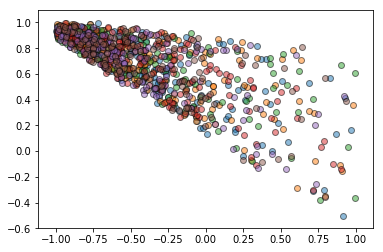

In [125]:
sample = data.sample(1000)

for s, sd in sample.groupby('sector'):
    plt.scatter(sd['dist_ecu'], sd['dist_ecv'], 
                alpha=0.5, marker='o', edgecolor='k')

In [126]:
from mpl_toolkits.mplot3d import Axes3D

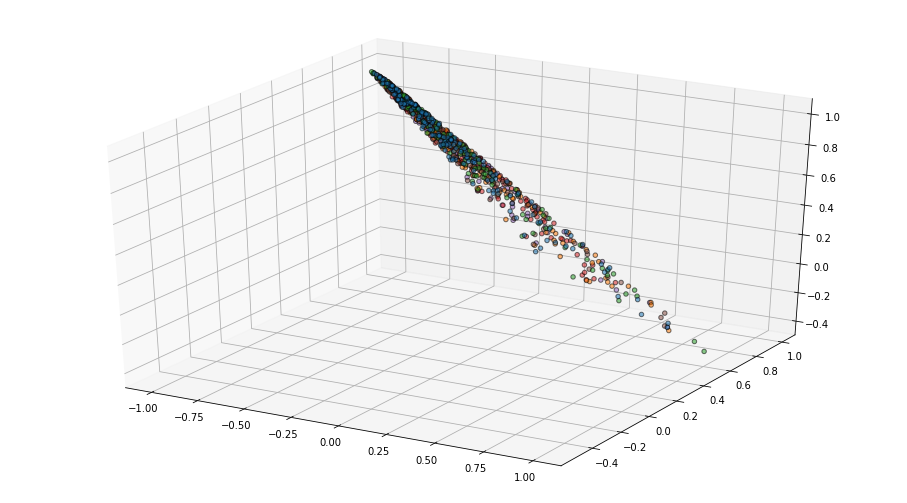

In [133]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

for s, sd in sample.groupby('sector'):
    ax.scatter(sd['dist_ecu'], sd['dist_ecv'], sd['dist_ecw'],
                alpha=0.55, marker='o', edgecolor='k')

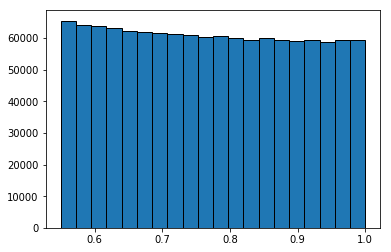

In [135]:
plt.hist(data['alpha'], edgecolor='k', bins=20);